In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tqdm import tqdm


In [2]:
# Create dataset loader class, this will read the dataset folder and create a dataset object
# where each element is a tuple of (image, [xc, yc, x1, y1, x2, y2, xv, yv]).
# The image is a 3D tensor of shape (3, 256, 256) and the ground-truth is a list of 8 floats read from
# the filename.
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # List all image files in the directory
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg') or f.endswith('.png')]
        self.image_files.sort()  # Sort the files to ensure consistent ordering
        # List of all ground-truth values
        self.gt_files = [f for f in os.listdir(root_dir) if f.endswith('.txt')]
        self.gt_files.sort()  # Sort the files to ensure consistent ordering

        # Ensure that the dataset is not empty
        if len(self.image_files) == 0:
            raise ValueError(f"No images found in the directory: {root_dir}")
        # Ensure that the ground-truth files match the images
        if len(self.image_files) != len(self.gt_files):
            raise ValueError(f"Number of images ({len(self.image_files)}) does not match number of ground-truth files ({len(self.gt_files)}) in the directory: {root_dir}")
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = datasets.folder.default_loader(img_name)
        if self.transform:
            image = self.transform(image)
        # Load the ground-truth
        gt_name = os.path.join(self.root_dir, self.gt_files[idx])
        with open(gt_name, 'r') as f:
            gt_values = f.read().strip().split(',')
            # Convert the ground-truth values to a list of floats
            gt_values = torch.tensor([float(x) for x in gt_values], dtype=torch.float32)
        # Ensure that the ground-truth values are in the correct format
        if len(gt_values) != 8:
            raise ValueError(f"Ground-truth file {gt_name} does not contain 8 values.")

        return image, gt_values


In [3]:
# Define a function to view samples from the dataset
def view_samples(dataset, num_samples=5):
    net_img_size = 200
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)
        image, gt_values = dataset[idx]
        axes[i].imshow(image.permute(1, 2, 0).numpy())
        # Plot center
        axes[i].plot(int(gt_values[0] * net_img_size), int(gt_values[1] * net_img_size), color='blue', marker='x', linewidth=2, markersize=12, markeredgewidth=4)
        # Plot Mark 1 - Minimum at scale (x1, y1)
        axes[i].plot(int(gt_values[2] * net_img_size), int(gt_values[3] * net_img_size), color='green', marker='x', linewidth=2, markersize=12, markeredgewidth=4)
        # Plot Mark 2 - Maximum at scale (x2, y2)
        axes[i].plot(int(gt_values[4] * net_img_size), int(gt_values[5] * net_img_size), color='yellow', marker='x', linewidth=2, markersize=12, markeredgewidth=4)
        # Plot Gauge Mark - Point of the tail (xv, yv)
        axes[i].plot(int(gt_values[6] * net_img_size), int(gt_values[7] * net_img_size), color='blue', marker='+', linewidth=2, markersize=12, markeredgewidth=4)        
        axes[i].set_title(f"idx: {idx}")
        axes[i].axis('off')
        if i == num_samples - 1:
            break
    plt.show()   

In [4]:
# Define the neural network model
class GaugeValueEstimatorModel(nn.Module):
    def __init__(self):
        super(GaugeValueEstimatorModel, self).__init__()
        # Backbone - Feature Extraction
        # Output_Shape = (Input_Shape - Kernel_Size + 2Padding) / Stride + 1*
        # Input: 3x200x200, Output: 64x200x200
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding='same')
        # Input : 64x200x200, Output: 64x100x100
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Input: 64x100x100, Output: 128x100x100
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same')
        # Input : 128x100x100, Output: 128x50x50
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Input: 128x50x50, Output: 256x50x50
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same')
        # # Input : 64x200x200, Output: 64x200x200
        # self.bn3 = nn.BatchNorm2d(64, momentum=0.99, eps=0.001)
        # Input: 256x50x50, Output: 256x25x25
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Input: 256x25x25, Output: 512x25x25
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding='same')

        # Head - Circle Parameters Regression
        # Input: 
        self.fc1 = nn.Linear(512*25*25, 256) # Adjust input size based on the output of the backbone
        self.fc2 = nn.Linear(256, 8)

    def forward(self, x):
        # Backbone
        x = F.relu(self.conv1(x))
        # x = self.bn1(x)
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        # x = self.bn2(x)
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        # x = self.bn3(x)
        x = self.pool3(x)

        x = F.relu(self.conv4(x))
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the fully connected layer

        # Head
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Linear activation for regression
        return x
    


In [5]:
# Define a function to train the model
def train_model(device, model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, gt_values in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            # Move data to the same device as the model
            images = images.to(device)
            gt_values = gt_values.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, gt_values)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Loss: {running_loss / len(train_loader)}")
    return model


# Define a function to test the model and return the predictions and ground-truth values and accuracy
def test_model(device, model, test_loader):
    model.eval()
    predictions = []
    ground_truths = []
    total_loss = 0.0
    criterion = nn.MSELoss()  # Define the loss function for accuracy calculation

    with torch.no_grad():
        for images, gt_values in tqdm(test_loader, desc="Testing"):
            # Move data to the same device as the model
            images = images.to(device)
            gt_values = gt_values.to(device)

            # Get model predictions
            outputs = model(images)
            predictions.append(outputs.cpu().numpy())
            ground_truths.append(gt_values.cpu().numpy())

            # Calculate loss for accuracy
            loss = criterion(outputs, gt_values)
            total_loss += loss.item()

    # Calculate overall accuracy (mean squared error in this case)
    accuracy = total_loss / len(test_loader)

    return predictions, ground_truths, accuracy


# Define a function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


# Define a function to load the model
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")
    return model


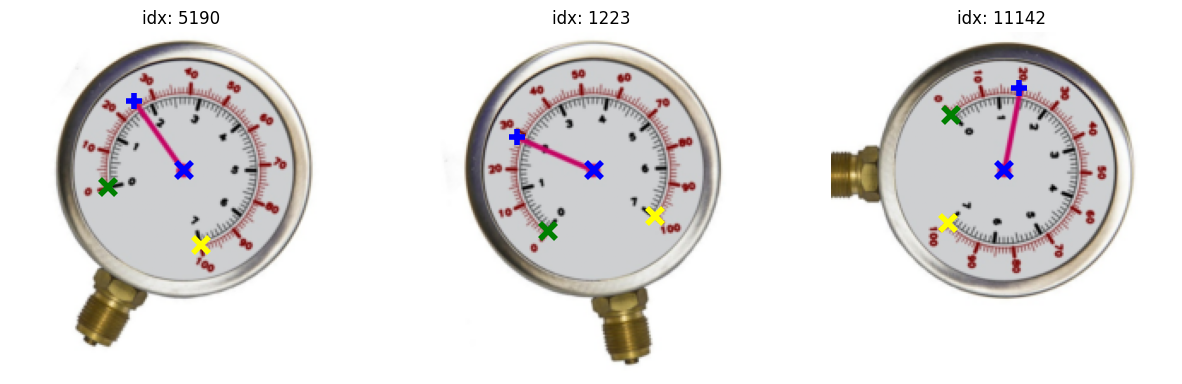

In [6]:
# Create a transformation for the dataset:
dataset_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
])
# Create a simple dataset
full_dataset = CustomDataset(root_dir='dataset', transform=dataset_transform)
# View samples from the dataset
view_samples(full_dataset, num_samples=3)

In [7]:
# Split dataset to train and test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model, define the loss function and the optimizer
model = GaugeValueEstimatorModel()
model.to(device)

criterion = nn.MSELoss()
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
print(model)

GaugeValueEstimatorModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=320000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)


In [ ]:
# Train the model
model = train_model(device, model, train_loader, criterion, optimizer, num_epochs=10)


In [ ]:
# Save the model
save_model(model, 'gauge_value_estimator.pth')

In [ ]:
# Load the model
model = load_model(model, 'gauge_value_estimator.pth')

In [ ]:
# Test the model and get accuracy
test_model(device, model, test_loader)

In [ ]:

.